# Importes

In [10]:
import random
import os
import pickle
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score, auc, log_loss
from sklearn.preprocessing import RobustScaler
import wandb

## Funciones

In [8]:
def conf_matrix(y_true, y_pred):
  cm = confusion_matrix(y_true=y_true, y_pred=y_pred)

  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix - Random Forest')
  plt.show()

def roc(y_true, y_pred):
  fpr, tpr, thresholds = roc_curve(y_true, y_pred)
  roc_auc = auc(fpr, tpr)

  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest')
  plt.legend(loc='lower right')
  plt.show()

def load_data():
  n=len(os.listdir('../data/business/'))-1
  path = f'../data/business/brest_cancer_{n}'
  df = pd.read_parquet(path)
  return df

def transform_data(df):
  mapa = {'Maligno':1, 'Benigno':0}
  df['Diagnóstico'] = df['Diagnóstico'].map(mapa)
  return df

def isDeterminictic(n):
  np.random.seed(n)
  random.seed(n)
  torch.manual_seed(n)
  torch.cuda.manual_seed_all(n)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

def split(df):
  X = df.drop(columns='Diagnóstico')
  y = df['Diagnóstico']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
  return (X_train, X_test, y_train, y_test)

def normalize(X_train, X_test, y_train, y_test, scaler):
  X_train = torch.tensor(scaler.fit_transform(X_train), dtype=torch.float)
  y_train = torch.tensor(y_train, dtype=torch.float)

  X_test = torch.tensor(scaler.fit_transform(X_test), dtype=torch.float)
  y_test = torch.tensor(y_test, dtype=torch.float)

  return (X_train, X_test, y_train, y_test)

def hyperparameters_tuning(model ,X, y):
  param_grid = {
      'n_estimators': [100, 200, 300],
      'criterion': ['gini', 'entropy'],
      'max_depth': [None, 10, 20],
      'max_features': ['auto', 'sqrt', 'log2'],
      'min_samples_split': [2, 5, 10],
      'min_samples_leaf': [1, 2, 4]
  }

  grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)
  grid_search.fit(X, y)

  print("Mejores hiperparámetros:", grid_search.best_params_)

  print("Puntuación del mejor modelo:", grid_search.best_score_)

  return grid_search.best_params_

def save_model(model, name):
  with open(f'{name}.pkl', 'wb') as file:
    pickle.dump(model, file)

# Ejecución

In [ ]:
df = load_data()

In [ ]:
df = transform_data(df)

## Visualización

In [ ]:
df.head()

,Diagnóstico,Radio medio,Textura media,Perímetro medio,Área media,Suavidad media,Compacidad media,Concavidad media,Puntos cóncavos medios,Simetría media,...,Peor radio,Peor textura,Peor perímetro,Peor área,Peor suavidad,Peor compacidad,Peor concavidad,Peor puntuación de los puntos cóncavos,Peor simetría,Peor dimensión fractal
0,Maligno,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,Maligno,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,Maligno,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,Maligno,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,Maligno,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Diagnóstico                             569 non-null    object 
 1   Radio medio                             569 non-null    float64
 2   Textura media                           569 non-null    float64
 3   Perímetro medio                         569 non-null    float64
 4   Área media                              569 non-null    float64
 5   Suavidad media                          569 non-null    float64
 6   Compacidad media                        569 non-null    float64
 7   Concavidad media                        569 non-null    float64
 8   Puntos cóncavos medios                  569 non-null    float64
 9   Simetría media                          569 non-null    float64
 10  Dimensión fractal media                 569 non-null    float6

### Distribución de las variables

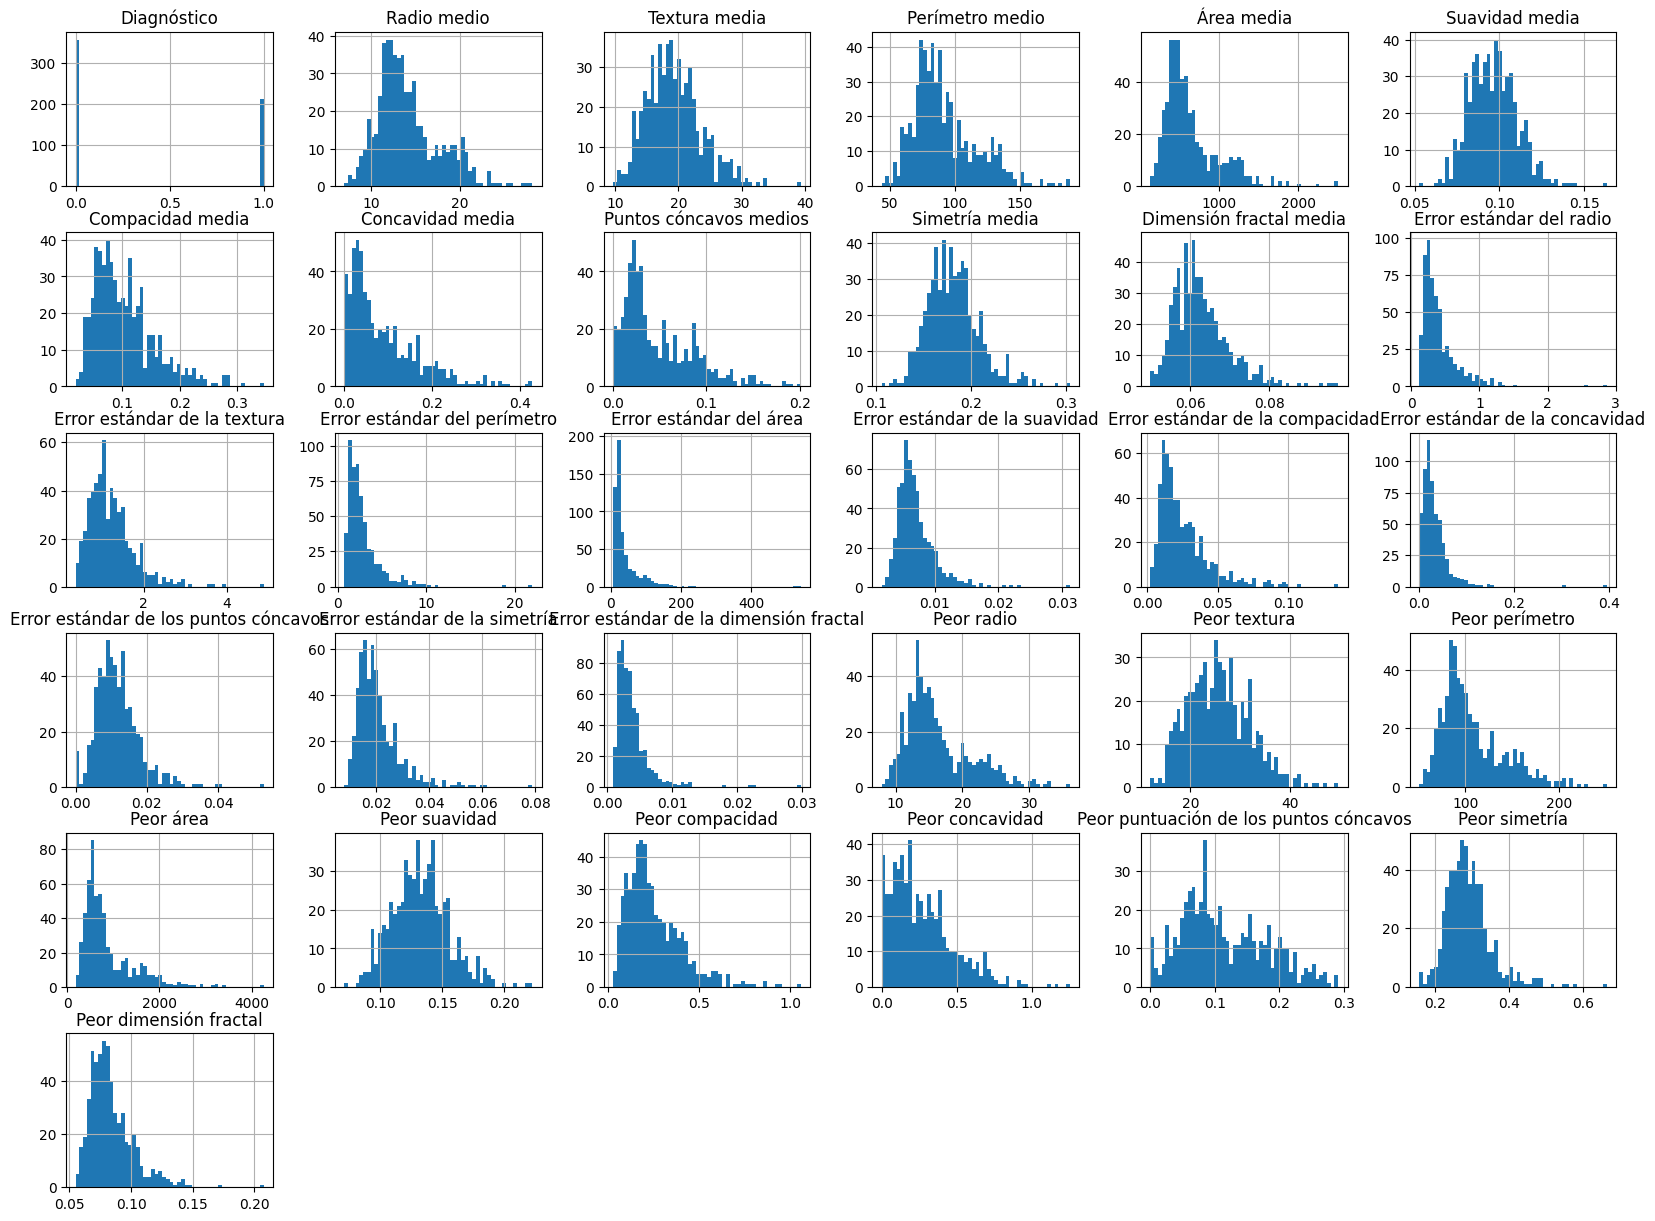

In [ ]:
df.hist(bins=50, figsize=(20,15));
plt.show();

### Estudio de Correlaciones

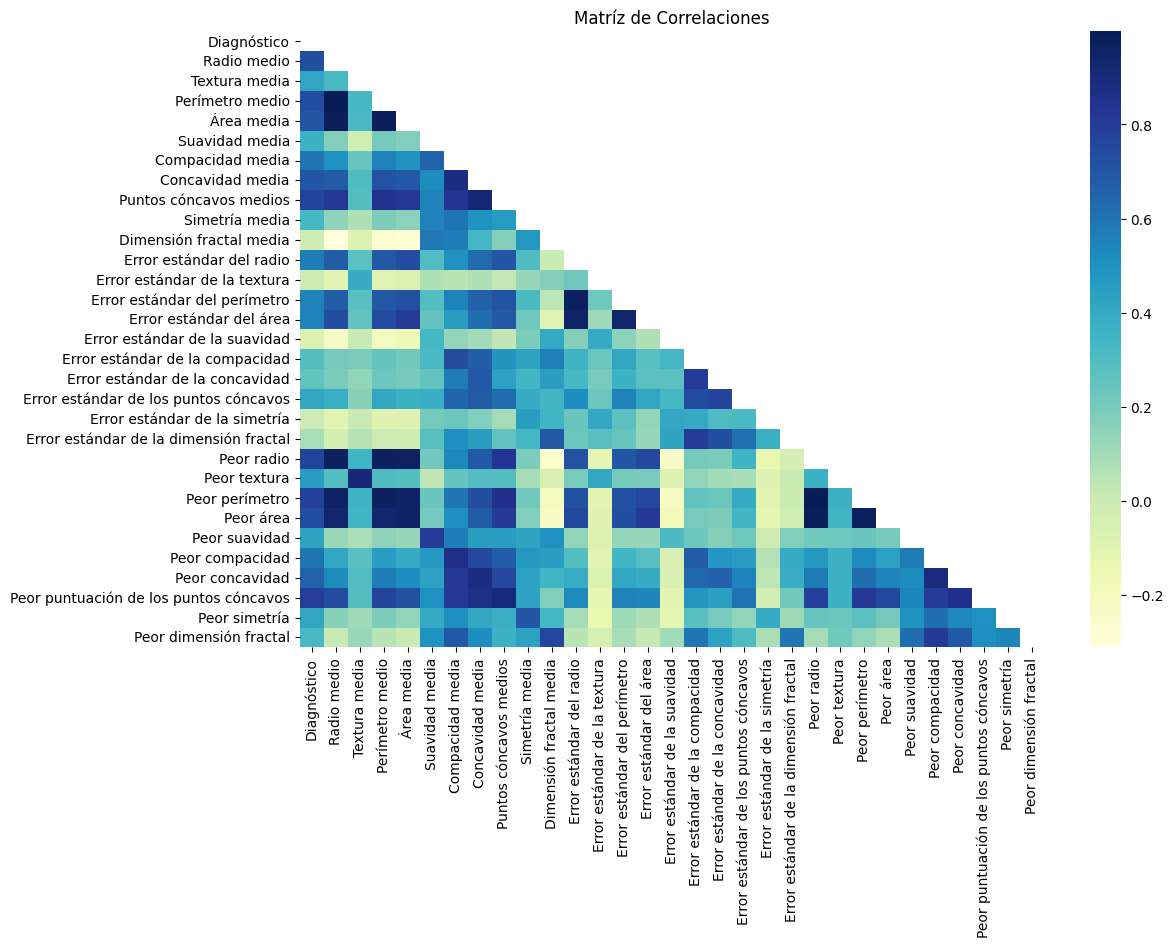

In [ ]:
correlation_matrix = df.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='YlGnBu', fmt='.2f', mask=mask)
plt.title('Matríz de Correlaciones')
plt.show()

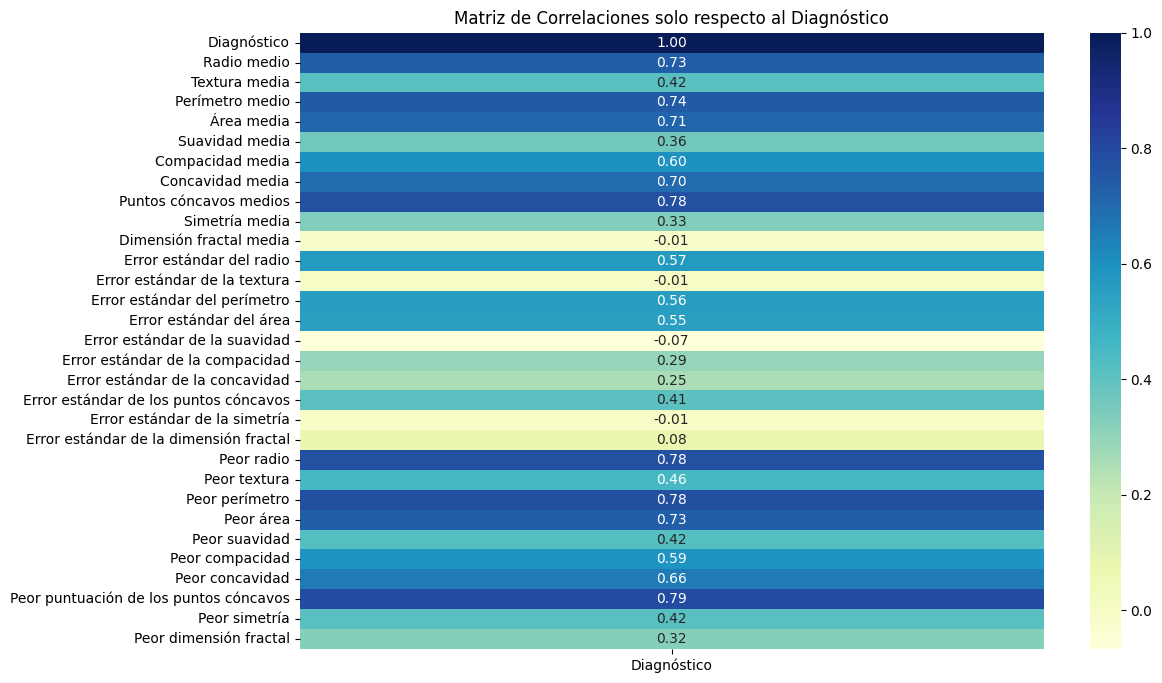

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix[['Diagnóstico']], annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Matriz de Correlaciones solo respecto al Diagnóstico')
plt.show()

## Entrenamiento y predicción

Definimos todas las seed para que el entrenamiento y predicción de los modelos pueda ser todo lo reproducible posible.

In [7]:
isDeterminictic(42)

Creamos los conjuntos de datos train y test

In [ ]:
X_train, X_test, y_train, y_test = split(df)

## Modelos

### Random Forest

In [ ]:
wandb.init(project='RandomForest_BrestCancer', entity='vapepa',
    config={
    "dataset": "Breast Cancer"
    })

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_rf)
loss = log_loss(y_test, y_pred_rf)

print("Random Forest Classifier:")
print(f"Precisión: {accuracy:.2f}")
print(classification_report(y_test, y_pred_rf))

wandb.log({'loss': loss.item(), 'accuracy': accuracy})
wandb.watch(rf_model)
torch.save(rf_model.state_dict(), 'model.pth')
wandb.save('model.pth')
wandb.finish()

In [ ]:
conf_matrix(y_test, y_pred_rf)

In [ ]:
roc(y_test, y_pred_rf)

### Búsqueda de hiperparámetros

Para optimizar el modelo realizaremos una búsqueda de hiperparámetros.

In [ ]:
rf_model = RandomForestClassifier(random_state=42)
best_params = hyperparameters_tuning(rf_model, X_train, y_train)

wandb.init(project='RandomForestHT_BrestCancer', entity='vapepa',
    config={
    "dataset": "Breast Cancer", best_params
    })

rf_model = RandomForestClassifier(**best_params ,random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_rf)
loss = log_loss(y_test, y_pred_rf)

print("Random Forest Classifier:")
print(f"Precisión: {accuracy:.2f}")
print(classification_report(y_test, y_pred_rf))

wandb.log({'loss': loss.item(), 'accuracy': accuracy})
wandb.watch(rf_model)
torch.save(rf_model.state_dict(), 'model.pth')
wandb.save('model.pth')
wandb.finish()

### Red Neuronal

Las redes neuronales necesitan de tensores para trabajar, así que lo primero que vamos hacer es convertir nuestros conjuntos de datos a tensores.

Y también normalizaremos los datos.

In [ ]:
scaler = RobustScaler()
X_train, X_test, y_train, y_test = normalize(X_train, X_test, y_train, y_test, scaler)

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(30, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [ ]:
wandb.init(project='NeuralNetwork_BrestCancer', entity='vapepa',
    config={
    "learning_rate": 0.0001,
    "weight_decay": 0.001,
    "architecture": "NN",
    "dataset": "Breast Cancer",
    "epochs": 5000,
    })

model_nn = NeuralNetwork()

criterion = nn.BCELoss()
optimizer = optim.RMSprop(model_nn.parameters(), lr=0.0001, weight_decay=0.001)

epochs = 5000
model_nn.train()
for epoch in range(epochs):
    outputs = model_nn(X_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

model_nn.eval()
y_pred_nn = model_nn(X_test)
y_pred_nn = y_pred_nn.detach().numpy().round()

accuracy = accuracy_score(y_test, y_pred_nn)

print("Red Neuronal:")
print(f"Precisión: {accuracy:.2f}")
print(classification_report(y_test, y_pred_nn))

wandb.log({'loss': loss.item(), 'accuracy': accuracy})
wandb.watch(model_nn)
torch.save(model_nn.state_dict(), 'model.pth')
wandb.save('model.pth')
wandb.finish()

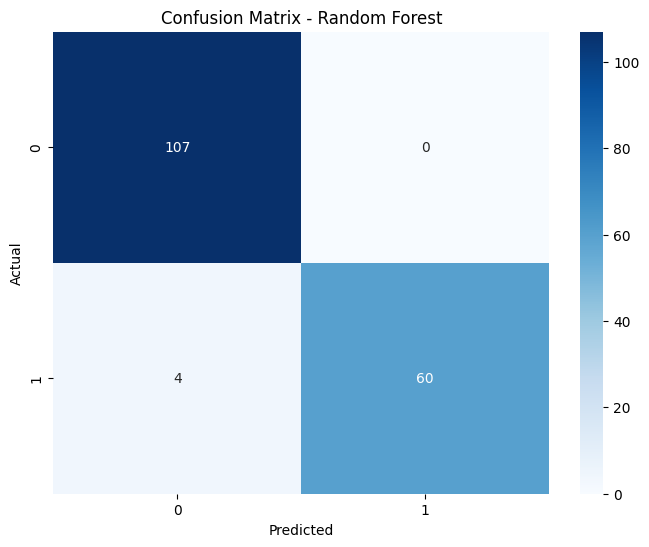

In [ ]:
conf_matrix(y_test, y_pred_nn)

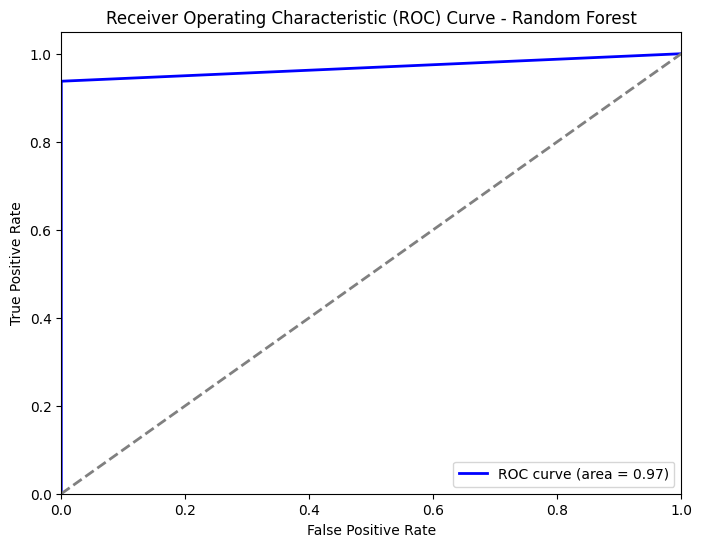

In [ ]:
roc(y_test, y_pred_nn)

La Red Neuronal arroja mejores resultados, así que será el modelo que elegiremos para nuestras predicciones.

In [ ]:
save_model(model_nn, 'model_nn')